In [67]:
import cv2
import imutils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as T
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from tempfile import TemporaryDirectory

import time
import os
from pathlib import Path

cudnn.benchmark = True
plt.ion()   # interactive mode

In [25]:
#Defining project directories
root_dir = Path.cwd().parent
data_dir = root_dir / 'data'
original_dir = data_dir / 'original'
train_dir = data_dir / 'train'
train_dir_cropped = data_dir / 'train_cropped'
test_dir = data_dir / 'test'
test_dir_cropped = data_dir / 'test_cropped'
validation_dir = data_dir / 'validate'
validation_dir_cropped = data_dir / 'validate_cropped'

In [27]:
#Applying augmentation and normalization to training images and only normalization to validation images

data_transforms = {
    'train_cropped': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ElasticTransform(alpha=30.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validate_cropped': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [28]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train_cropped', 'validate_cropped']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train_cropped', 'validate_cropped']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train_cropped', 'validate_cropped']}

class_names = image_datasets['train_cropped'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

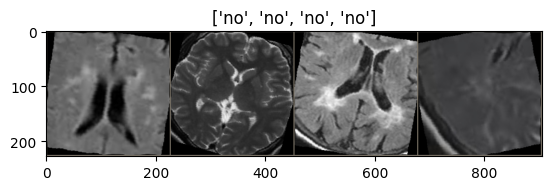

In [32]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train_cropped']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train_cropped', 'validate_cropped']:
                if phase == 'train_cropped':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train_cropped'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train_cropped':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train_cropped':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'validate_cropped' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [36]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [37]:
#Takes around 25 min to train
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train_cropped Loss: 0.7020 Acc: 0.6270
validate_cropped Loss: 0.5579 Acc: 0.7185

Epoch 1/24
----------
train_cropped Loss: 0.6518 Acc: 0.6595
validate_cropped Loss: 0.3884 Acc: 0.8444

Epoch 2/24
----------
train_cropped Loss: 0.6217 Acc: 0.6811
validate_cropped Loss: 0.4766 Acc: 0.7926

Epoch 3/24
----------
train_cropped Loss: 0.6086 Acc: 0.7081
validate_cropped Loss: 0.3062 Acc: 0.9037

Epoch 4/24
----------
train_cropped Loss: 0.6205 Acc: 0.7027
validate_cropped Loss: 0.4060 Acc: 0.8074

Epoch 5/24
----------
train_cropped Loss: 0.5276 Acc: 0.7892
validate_cropped Loss: 0.1911 Acc: 0.9037

Epoch 6/24
----------
train_cropped Loss: 0.5614 Acc: 0.7730
validate_cropped Loss: 0.2451 Acc: 0.8963

Epoch 7/24
----------
train_cropped Loss: 0.3942 Acc: 0.8270
validate_cropped Loss: 0.1884 Acc: 0.9333

Epoch 8/24
----------
train_cropped Loss: 0.5569 Acc: 0.7730
validate_cropped Loss: 0.2120 Acc: 0.9111

Epoch 9/24
----------
train_cropped Loss: 0.4136 Acc: 0.7946
val

In [39]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
def predict_image(model, img_path):
    img = Image.open(img_path)
    img = data_transforms['validate_cropped'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        return class_names[preds[0]]
    
#predicting on test images
test_data = datasets.ImageFolder(test_dir_cropped)

def predict_on_test_folder(model, test_folder):
    predictions = []
    for labels in os.listdir(test_folder):
        for img in os.listdir(os.path.join(test_folder, labels)):
            predictions.append(predict_image(model, os.path.join(test_folder, labels, img)))
    return predictions

In [52]:
predictions = predict_on_test_folder(model_ft, test_dir_cropped)

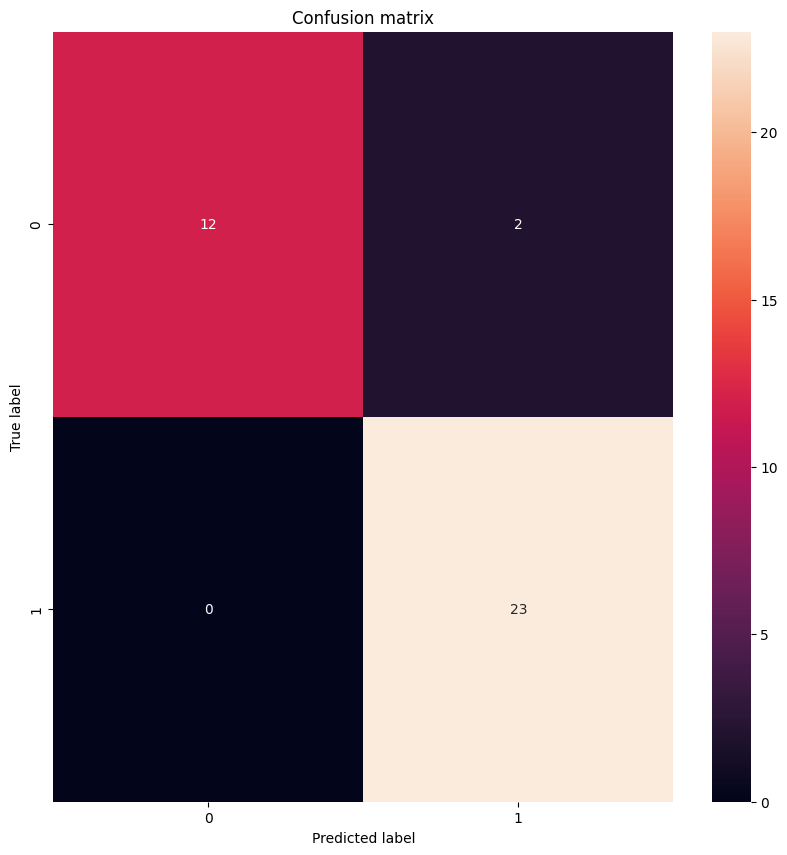

              precision    recall  f1-score   support

          no       1.00      0.86      0.92        14
         yes       0.92      1.00      0.96        23

    accuracy                           0.95        37
   macro avg       0.96      0.93      0.94        37
weighted avg       0.95      0.95      0.94        37



In [69]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(predictions, labels):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

true_labels = [class_names[label] for label in test_data.targets]
plot_confusion_matrix(predictions, true_labels)

print(classification_report(true_labels, predictions))
